In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os.path as path
import matplotlib.ticker as ticker
from scipy.integrate import simps, trapz


import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : True ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : True ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight'
})

In [3]:
!pwd

/home/hyejin/Desktop/my_git/DMFT_NN/2_nn


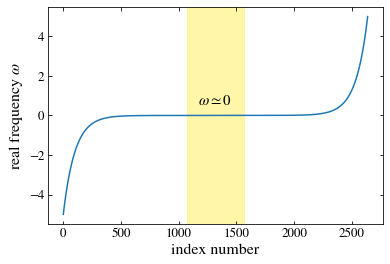

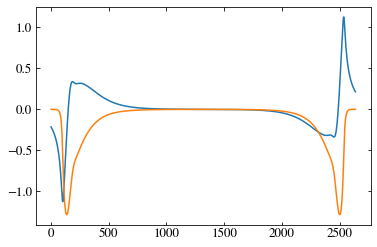

In [4]:
D = 1
out_node = 2
directory = '../1_dmftsolver/NRG'

w, A,Gr,Gi,_,_,_,_,_,_ = np.loadtxt(f'{directory}/Bethe_41_beta10000/Bethe-{2.25:.3f}.dat', \
                       unpack = True, dtype = 'complex128')
plt.plot(w.real)
plt.ylabel(r'real frequency $\omega$')
plt.xlabel('index number')
plt.axvspan(1319-250, 1319+250, alpha=0.5, color='#ffee52')
plt.annotate(r'$\omega\simeq0$', xy=(0.5, 0.55), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.savefig('index2w.png')
plt.show()


plt.plot(Gr.real)
plt.plot(Gi.real)

# Neural Network

### ED data

In [12]:
def EDbath(e, V):
    return np.array([np.sum(V**2/(1j*omega[i]-e)) for i in range (aa)])
beta = 100
directory1 = '../1_dmftsolver/ED'
a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{3.00:.2f}', dtype = 'float64')
iw, Giwr, Giwi = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/Giw-{3.00:.2f}.dat',\
                                       unpack = True, dtype = 'float64')
e, V = a[:5], a[5:]

aa = 10000
omega = np.pi/beta * (2*np.arange(aa)+1)

In [32]:
beta = 100
directory1 = '../1_dmftsolver/ED'
up_num = 211
dn_num = 211
U = np.array([0.01*i for i in range(50, 501)])
U1_ed = np.zeros(up_num, dtype = 'float64')
U2_ed = np.zeros(dn_num, dtype = 'float64')
U_c1_ed, U_c2_ed = 2.4, 2.93


n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U1_ed[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U2_ed[n] = u
    n += 1

x_test_ed = np.zeros((len(U1_ed)+len(U2_ed), 10000), dtype = 'float64')
UU1 = U1_ed[U1_ed<2.0]
UU2 = U2_ed[U2_ed>3.0]
x = np.zeros((len(UU1)+len(UU2), 10000), dtype = 'float64')

for i,u in enumerate(U1_ed):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed[i][:aa] = EDbath(e,V).imag
for i,u in enumerate(U2_ed):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed[i+len(U1_ed)][:aa] = EDbath(e,V).imag
    
for i,u in enumerate(UU1):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x[i][:aa] = EDbath(e,V).imag
for i,u in enumerate(UU2):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x[i+len(UU1)][:aa] = EDbath(e,V).imag
    
x_test_ed = -torch.FloatTensor(x_test_ed)
x = -torch.FloatTensor(x)

y_temp1 = np.array(U1_ed < U_c2_ed)
y_temp2 = np.array(U2_ed < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_ed = np.stack([y_temp, ~y_temp], axis = 1)
y_test_ed = torch.FloatTensor(y_test_ed)

y_temp1 = np.array(UU1 < U_c2_ed)
y_temp2 = np.array(UU2 < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y = np.stack([y_temp, ~y_temp], axis = 1)
y = torch.FloatTensor(y)
UU_ed = np.concatenate((U1_ed, U2_ed))

def divide(x_, y_):
    mask = np.random.rand(len(x_)) < 0.9  # train : val = 4 : 1
    x_train, x_val = x_[mask], x_[~mask]
    y_train, y_val = y_[mask], y_[~mask]
    return x_train, x_val, y_train, y_val
x_train, x_val, y_train, y_val = divide(x, y)

In [33]:
size = len(x[0])
class Net(nn.Module):
    def __init__(self, node = None, activate = None):
        super(Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(size, self.node)#, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        #self.W1.weight.data.fill_(0)
        nn.init.uniform_(self.W1.weight, -0.001, 0.001)
        nn.init.xavier_normal_(self.W2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)
        '''
        if (activate==nn.Sigmoid or activate==nn.Tanh):
            nn.init.xavier_normal_(self.W1.weight)
            nn.init.xavier_normal_(self.W2.weight)
        else:
            nn.init.kaiming_normal_(self.W1.weight)
            nn.init.kaiming_normal_(self.W2.weight)
        '''

    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)

    def loss1(self, output, y, reg): # regularization l1
        regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    def loss2(self, output, y, reg): # regularization l2
        regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss

    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

In [44]:
learning_rate = 1e-2
reg = 1e-4
func = nn.Sigmoid
h_node = 10
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
#model = Net(node = h_node, activate = func)
n_epochs = 2000
train_loss, val_loss, test_acc = np.ones(n_epochs+1), np.ones(n_epochs+1), np.ones(n_epochs+1)
for epoch in range (n_epochs+1):
    loss = model.loss1(model.forward(x_train), y_train, reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valid_loss = model.loss1(model.forward(x_val), y_val, reg).item()
    t_acc = model.accuracy(model.forward(x_test_ed), y_test_ed)
    train_loss[epoch], val_loss[epoch], test_acc[epoch] = loss.item(), valid_loss, t_acc

    if epoch%int(n_epochs/10) == 0:
        print('epoch = %d, training loss = %.6f, valid loss = %.6f, accuracy = %.8f' \
                %(epoch, loss.item(), valid_loss, t_acc))

epoch = 0, training loss = 0.048054, valid loss = 0.051461, accuracy = 0.94786730
epoch = 200, training loss = 0.047776, valid loss = 0.051142, accuracy = 0.94786730
epoch = 400, training loss = 0.047507, valid loss = 0.050833, accuracy = 0.94786730
epoch = 600, training loss = 0.047246, valid loss = 0.050534, accuracy = 0.94786730
epoch = 800, training loss = 0.046993, valid loss = 0.050242, accuracy = 0.94786730
epoch = 1000, training loss = 0.046747, valid loss = 0.049959, accuracy = 0.94786730
epoch = 1200, training loss = 0.046509, valid loss = 0.049684, accuracy = 0.94786730
epoch = 1400, training loss = 0.046278, valid loss = 0.049417, accuracy = 0.94786730
epoch = 1600, training loss = 0.046053, valid loss = 0.049158, accuracy = 0.94786730
epoch = 1800, training loss = 0.045835, valid loss = 0.048905, accuracy = 0.94786730
epoch = 2000, training loss = 0.045623, valid loss = 0.048660, accuracy = 0.94786730


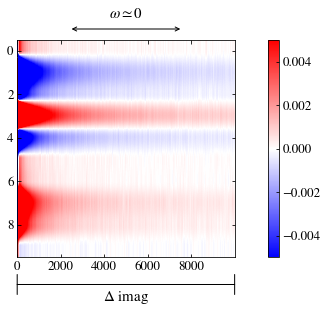

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
op = {'vmin': -0.005, 'vmax': 0.005}
im1 = ax.imshow(np.array(model.W1.weight.data), aspect=10000/10, cmap='bwr', **op)
#im2 = ax[1].imshow(Weight*number, aspect=2000/h_node, cmap='bwr', **OP)
import matplotlib.ticker as ticker
#ax[1].xaxis.set_major_locator(ticker.MultipleLocator(500))
#ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1f'%((x-1000)/200)))
#ax[1].set_xlabel(r'$\omega$')
ax.annotate('', xy=(0, -0.125), xytext=(1, -0.125), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0})

ax.annotate('', xy=(0.25, 1.05), xytext=(0.75, 1.05), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'<->', 'shrinkA':0, 'shrinkB':0})
ax.annotate(r'$\omega\simeq0$', xy=(0.5, 1.1), xycoords = 'axes fraction', fontsize=15, ha='center')
ax.annotate(r'$\Delta$ imag', xy=(0.5, -0.2), xycoords = 'axes fraction', fontsize=15, ha='center')

cd = plt.colorbar(im1, ax=ax)
#cd = plt.colorbar(im2, ax=ax[1])
#plt.savefig('NN_Weight_u0.001_10.png')
plt.show()

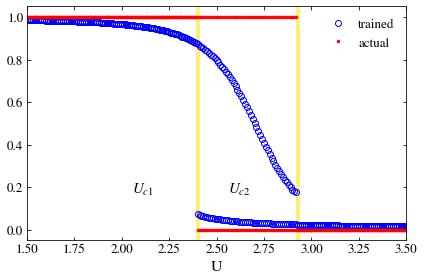

In [46]:
plt.axvline(U_c1_ed, c = '#ffee52', lw = '4',  alpha=0.8)
plt.axvline(U_c2_ed, c = '#ffee52', lw = '4',  alpha=0.8)
plt.plot(UU_ed, model.forward(x_test_ed).data[:,0], 'bo', mfc='none', label = 'trained')
#plt.plot(UU_ed, x_test_ed[:,0]/torch.max(x_test_ed[:, 0]), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
#plt.plot(UU_ed, np.average(x_test_ed[:,0:150], axis=1)/np.max(np.average(x_test_ed[:,0:150], axis=1)), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
plt.plot(UU_ed, y_test_ed[:,0], 'r.', ms = 5, label = 'actual')
plt.xlim(1.5, 3.5)
plt.xlabel('U')
plt.annotate(r'$U_{c1}$', xy=(0.305, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
plt.annotate(r'$U_{c2}$', xy=(0.56, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.title(r'$\beta=100$', fontsize=16)
plt.legend()

plt.tight_layout(w_pad=1.5)
#plt.savefig('LogisticRegression_outputcubic_u0.001.png')

## Saving result

In [496]:
model.W1.weight.data.shape, model.W2.weight.data.shape, Weight.shape, W_iw_eff.shape

(torch.Size([10, 2638]), torch.Size([2, 10]), (10, 2001), (10, 10000))

In [50]:
torch.save(model.W1.weight.data, 'frozen_mat/iw_NN10_W1.pt')
torch.save(model.W2.weight.data, 'frozen_mat/iw_NN10_W2.pt')
torch.save(model.b1.weight.data, 'frozen_mat/iw_NN10_b1.pt')
torch.save(model.b2.weight.data, 'frozen_mat/iw_NN10_b2.pt')

In [56]:
net = Net(node = h_node, activate = func)
torch.save(model.state_dict(), 'iNN10model.pth')
net.load_state_dict(torch.load('iNN10model.pth'))

<All keys matched successfully>